<a href="https://colab.research.google.com/github/shamim-hussain/cnn_vae_gan_rl/blob/main/cnn_on_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Classification using a 2 Layer Neural Network
### Problem Description
We will perform a classification task on the Fashion MNIST dataset:
https://github.com/zalandoresearch/fashion-mnist
The dataset contains 28x28 grayscale(8bit) images of different fashion articles. There are 10 different classes. The training set contains 60000 examples whereas the test set contains 10000 examples. All the classes have same number of examples so it is a blanced classification problem.
### Framework of choice
We will use the Tensorflow framework for this task. We will use an object oriented approach to model definition. We will define the layers in terms of very basic equations (tensor multiplication, addition, activation etc.). Also, we will define our own custom training loop.

## Download the Dataset

The download links and the coad for loading the dataset in NumPy format can be found at https://github.com/zalandoresearch/fashion-mnist

In [ ]:
'''From: https://github.com/zalandoresearch/fashion-mnist'''

!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2021-10-26 03:45:12--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.171.16
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.171.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  11.2MB/s    in 2.2s    

2021-10-26 03:45:14 (11.2 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2021-10-26 03:45:14--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.171.16
Connecting to fashion-mnist.s3-website.eu-central-1.amaz

Load the dataset in NumPy format

In [1]:

'''From: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py'''
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

X_train, Y_train = load_mnist('./', kind='train') # Training set
X_test, Y_test = load_mnist('./', kind='t10k') # Test set

## Explore and Preprocess the data

Let us first explore the shape and datatypes of the examples and labels

In [2]:
print('Shape of data:', X_train.shape)
print('Type of data:', X_train.dtype)
print('Shape of data:', Y_train.shape)
print('Type of labes:', Y_train.dtype)

Shape of data: (60000, 784)
Type of data: uint8
Shape of data: (60000,)
Type of labes: uint8


We can reshape and visualize images from each class

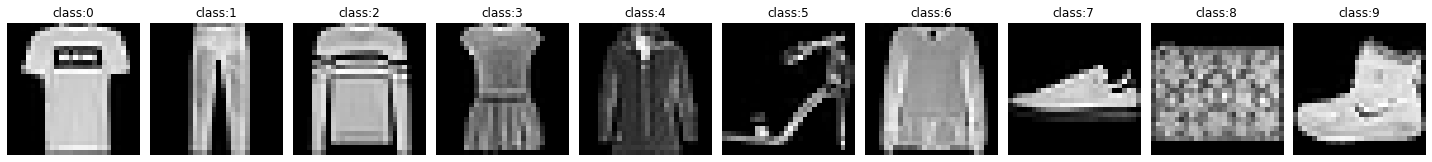

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Visualize data
plt.figure(figsize=[20,5])
for y in range(10):
    plt.subplot(1,10,1+y)
    plt.imshow(X_train[np.where(Y_train==y)[0][0]].reshape(28,28),cmap='gray')
    plt.axis('off')
    plt.title(f'class:{y}')
plt.tight_layout()
plt.show()

### Conversion into floating point image with channel dimension

In [4]:
X_train = X_train.reshape(-1,28,28,1).astype('float32')/255
X_test = X_test.reshape(-1,28,28,1).astype('float32')/255

Y_train = Y_train.astype('int64')
Y_test = Y_test.astype('int64')

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1,
                                                  stratify=Y_train, random_state=777)

# Model definition and training

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, losses, metrics


dropout_prob = 0.2
l2_reg = regularizers.l2(5e-4)
channel_mult = 1

model_layers = [
    layers.ZeroPadding2D(2, name='pad2', input_shape=(28,28,1)),
    layers.Conv2D(filters=round(32*channel_mult), kernel_size=(5,5), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv11'),
    layers.Dropout(dropout_prob, name='drp11'),

    layers.Conv2D(filters=round(32*channel_mult), kernel_size=(5,5), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv12'),
    layers.Dropout(dropout_prob, name='drp12'),
    layers.MaxPool2D((4,4), name='pool1'),


    layers.Conv2D(filters=round(64*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv21'),
    layers.Dropout(dropout_prob, name='drp21'),

    layers.Conv2D(filters=round(64*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv22'),
    layers.Dropout(dropout_prob, name='drp22'),
    layers.MaxPool2D((2,2), name='pool2'),


    layers.Flatten(name='flatten'),
    layers.Dense(round(64*channel_mult), kernel_regularizer=l2_reg, activation='elu', name='dense1'),
    layers.Dense(10, activation=None, name='dense2')
]

model = models.Sequential(model_layers, name='trained_on_given_data')

lr_schedule = optimizers.schedules.ExponentialDecay(1e-3, len(X_train)//64, 0.9)
optim = optimizers.Adam(lr_schedule)
loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True, name='xent')
acc = metrics.SparseCategoricalAccuracy(name='acc')

model.compile(optim, loss_fn, [acc])
model.summary()

Model: "trained_on_given_data"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pad2 (ZeroPadding2D)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv11 (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
drp11 (Dropout)              (None, 32, 32, 32)        0         
_________________________________________________________________
conv12 (Conv2D)              (None, 32, 32, 32)        25632     
_________________________________________________________________
drp12 (Dropout)              (None, 32, 32, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 8, 8, 32)          0         
_________________________________________________________________
conv21 (Conv2D)              (None, 8, 8, 64)

In [7]:
hist_obj = model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_val, Y_val))

Epoch 1/50
844/844 [==============================] - 5s 6ms/step - loss: 0.6117 - acc: 0.8243 - val_loss: 0.4738 - val_acc: 0.8707
Epoch 2/50
844/844 [==============================] - 5s 6ms/step - loss: 0.4402 - acc: 0.8805 - val_loss: 0.3891 - val_acc: 0.8973
Epoch 3/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3904 - acc: 0.8931 - val_loss: 0.3698 - val_acc: 0.8978
Epoch 4/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3607 - acc: 0.9021 - val_loss: 0.3557 - val_acc: 0.9003
Epoch 5/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3381 - acc: 0.9086 - val_loss: 0.3676 - val_acc: 0.8995
Epoch 6/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3218 - acc: 0.9128 - val_loss: 0.3217 - val_acc: 0.9117
Epoch 7/50
844/844 [==============================] - 5s 6ms/step - loss: 0.3083 - acc: 0.9166 - val_loss: 0.3174 - val_acc: 0.9162
Epoch 8/50
844/844 [==============================] - 5s 6ms/step - loss: 0.

In [8]:
loss, acc = model.evaluate(X_test, Y_test, batch_size=64)
print(f'Test accuracy with given data: {acc:0.3%}')

157/157 [==============================] - 0s 3ms/step - loss: 0.2835 - acc: 0.9265
Test accuracy with given data: 92.650%


## Augmentation

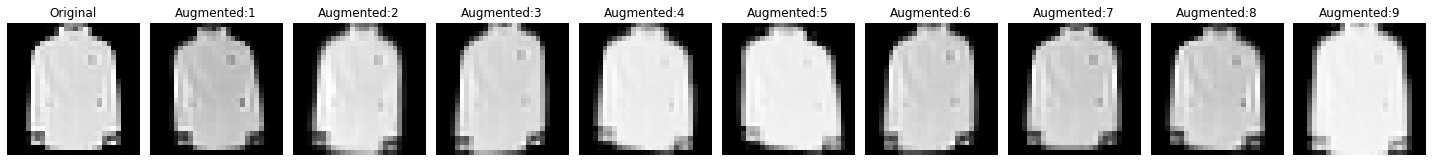

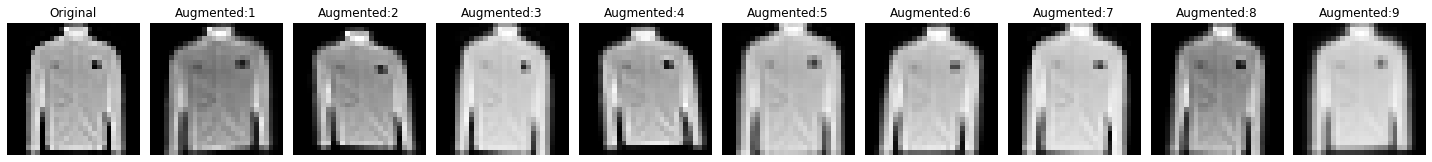

In [9]:
import cv2
import random

ref_pts = np.float32([[8, 8], [8, 17], [17, 14]])

def augment_affine(X):
    rand_val = np.random.uniform(low=-.5, high=.5, 
                                 size=(3,2)).astype(np.float32)
    dst_pts = ref_pts + rand_val
    M = cv2.getAffineTransform(ref_pts,dst_pts)
    return cv2.warpAffine(X, M, (28,28))

def augment_gamma(X):
    rand_val = np.random.uniform(low=.5, high=2., 
                                 size=()).astype(np.float32)
    return X ** rand_val

def augment_gaussian(X):
    rand_val = np.random.uniform(low=0., high=.5, 
                                 size=()).astype(np.float32)
    return cv2.GaussianBlur(X, (5,5), rand_val)

augment_fns = [augment_gaussian,augment_gamma,augment_affine]
def augment(X, multiples):
    out = []
    for _ in range(multiples):
        X_t = X
        random.shuffle(augment_fns)
        for f in augment_fns:
            X_t = f(X_t)
        out.append(X_t)
    return out

plt.figure(figsize=[20,5])
original = X_train[0].squeeze()
augmented = augment(original, 9)

plt.subplot(1,10,1)
plt.imshow(original,cmap='gray')
plt.axis('off')
plt.title(f'Original')
for y in range(9):
    plt.subplot(1,10,2+y)
    plt.imshow(augmented[y],cmap='gray')
    plt.axis('off')
    plt.title(f'Augmented:{y+1}')
plt.tight_layout()


plt.figure(figsize=[20,5])
original = X_train[4].squeeze()
augmented = augment(original, 9)

plt.subplot(1,10,1)
plt.imshow(original,cmap='gray')
plt.axis('off')
plt.title(f'Original')
for y in range(9):
    plt.subplot(1,10,2+y)
    plt.imshow(augmented[y],cmap='gray')
    plt.axis('off')
    plt.title(f'Augmented:{y+1}')
plt.tight_layout()

In [10]:
from tqdm import tqdm

multiples = 9

X_train_augmented = []
Y_train_augmented = []

for X,Y in tqdm(zip(X_train.squeeze(-1), Y_train), 
                total=len(Y_train)):
    X_train_augmented.extend(augment(X,multiples))
    Y_train_augmented.extend([Y]*multiples)

X_train_augmented = np.expand_dims(np.stack(X_train_augmented, axis=0), axis=-1)
Y_train_augmented = np.stack(Y_train_augmented)

X_train_augmented = np.concatenate([X_train, X_train_augmented],axis=0)
Y_train_augmented = np.concatenate([Y_train, Y_train_augmented],axis=0)

100%|██████████████████████████████████████████████████████████████████████████| 54000/54000 [00:24<00:00, 2210.58it/s]


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, losses, metrics


dropout_prob = 0.1
l2_reg = regularizers.l2(5e-4)
channel_mult = 2

model_layers = [
    layers.ZeroPadding2D(2, name='pad2', input_shape=(28,28,1)),
    layers.Conv2D(filters=round(32*channel_mult), kernel_size=(5,5), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv11'),
    layers.Dropout(dropout_prob, name='drp11'),

    layers.Conv2D(filters=round(32*channel_mult), kernel_size=(5,5), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv12'),
    layers.Dropout(dropout_prob, name='drp12'),
    layers.MaxPool2D((2,2), name='pool1'),


    layers.Conv2D(filters=round(64*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv21'),
    layers.Dropout(dropout_prob, name='drp21'),

    layers.Conv2D(filters=round(64*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv22'),
    layers.Dropout(dropout_prob, name='drp22'),
    layers.MaxPool2D((2,2), name='pool2'),

    layers.Conv2D(filters=round(128*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv31'),
    layers.Dropout(dropout_prob, name='drp31'),

    layers.Conv2D(filters=round(128*channel_mult), kernel_size=(3,3), activation='elu',
                                padding='same', kernel_regularizer=l2_reg, name='conv32'),
    layers.Dropout(dropout_prob, name='drp32'),
    layers.MaxPool2D((2,2), name='pool3'),


    layers.Flatten(name='flatten'),
    layers.Dense(round(64*channel_mult), kernel_regularizer=l2_reg, activation='elu', name='dense1'),
    layers.Dense(10, activation=None, name='dense2')
]

model_augmented = models.Sequential(model_layers, name='trained_on_augmented')

lr_schedule = optimizers.schedules.ExponentialDecay(1e-3, len(X_train)//64, 0.95)
optim = optimizers.Adam(lr_schedule)
loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True, name='xent')
acc = metrics.SparseCategoricalAccuracy(name='acc')

model_augmented.compile(optim, loss_fn, [acc])
model_augmented.summary()

Model: "trained_on_augmented"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pad2 (ZeroPadding2D)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv11 (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
drp11 (Dropout)              (None, 32, 32, 64)        0         
_________________________________________________________________
conv12 (Conv2D)              (None, 32, 32, 64)        102464    
_________________________________________________________________
drp12 (Dropout)              (None, 32, 32, 64)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv21 (Conv2D)              (None, 16, 16, 12

In [14]:
hist_obj_augmented = model_augmented.fit(X_train_augmented, Y_train_augmented, batch_size=64, epochs=20, validation_data=(X_val, Y_val))


Epoch 1/20
8438/8438 [==============================] - 113s 13ms/step - loss: 0.4783 - acc: 0.8873 - val_loss: 0.3614 - val_acc: 0.9173
Epoch 2/20
8438/8438 [==============================] - 114s 13ms/step - loss: 0.3290 - acc: 0.9225 - val_loss: 0.3084 - val_acc: 0.9303
Epoch 3/20
8438/8438 [==============================] - 114s 14ms/step - loss: 0.2704 - acc: 0.9388 - val_loss: 0.2936 - val_acc: 0.9292
Epoch 4/20
8438/8438 [==============================] - 114s 14ms/step - loss: 0.2305 - acc: 0.9511 - val_loss: 0.2803 - val_acc: 0.9385
Epoch 5/20
8438/8438 [==============================] - 114s 14ms/step - loss: 0.2007 - acc: 0.9610 - val_loss: 0.2811 - val_acc: 0.9370
Epoch 6/20
8438/8438 [==============================] - 112s 13ms/step - loss: 0.1797 - acc: 0.9682 - val_loss: 0.2802 - val_acc: 0.9410
Epoch 7/20
8438/8438 [==============================] - 109s 13ms/step - loss: 0.1661 - acc: 0.9729 - val_loss: 0.2884 - val_acc: 0.9383
Epoch 8/20
8438/8438 [===================

In [15]:
loss, acc = model_augmented.evaluate(X_test, Y_test, batch_size=64)
print(f'Test accuracy with augmented data: {acc:0.3%}')

157/157 [==============================] - 1s 5ms/step - loss: 0.3219 - acc: 0.9353
Test accuracy with augmented data: 93.530%
